## Data generation

In [361]:
"""Script to generate, load and plot data."""
import matplotlib.pyplot as plt
import numpy as np


def generate_data(inputs: np.ndarray, flip_prob: float = 0, freq=2 * np.pi / 10):
    """Function used to generate noisy data."""
    data = np.greater(np.sin((freq) * inputs - np.pi), 0)
    # flip some labels randomly
    noisy_data = np.array([not x if np.random.random() < flip_prob else x for x in data])
    # center points around 0
    data = (data * 2) - 1
    noisy_data = (noisy_data * 2) - 1
    return data, noisy_data

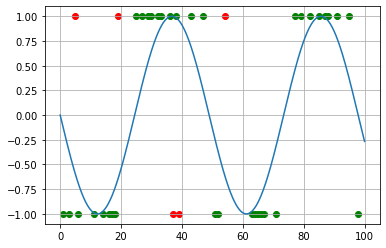

In [394]:
points = np.arange(0, 100, 1)
X = np.random.choice(points,40,replace=False)

freq= np.pi*np.random.rand()*.1
labels, Y = generate_data(X, flip_prob=0.1,freq=freq)

# Save data
np.savetxt("../data/custom_dataset.txt", np.array([X, Y, labels]).T,fmt="%2d")

# Load data
dataset = np.loadtxt("../data/custom_dataset.txt")

X = np.array(dataset[:, :-2])
Y = np.array(dataset[:, -2])
labels = np.array(dataset[:, -1])

# Plot data
x_points = np.linspace(0, 100, 1000)

# for xc in X[Y == labels]:
#     plt.axvline(x=xc, color="green", linestyle="--", linewidth=0.5)

# for xc in X[Y != labels]:
#     plt.axvline(x=xc, color="red", linestyle="--", linewidth=0.5)

plt.scatter(X[Y == labels], Y[Y == labels], color="green")
plt.scatter(X[Y != labels], Y[Y != labels], color="red")

plt.plot(x_points, np.sin(freq * x_points - np.pi))
plt.grid()
plt.show()

## Trivial quantum model that overfits

In [395]:
import pennylane as qml
from pennylane import numpy as pnp
from pennylane.optimize import NesterovMomentumOptimizer, AdamOptimizer
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output

In [396]:
dev = qml.device("default.qubit", wires=1)
@qml.qnode(dev)
def circuit(weights,scaling,input_data):
    for layer in range(len(weights)):
        qml.RX(input_data*scaling[layer],wires=0)
        qml.RY(weights[layer],wires=0)
    return qml.expval(qml.PauliZ(0))

def square_loss(labels, predictions):
    """Square loss."""
    loss = sum((label - prediction) ** 2 for label, prediction in zip(labels, predictions))
    loss /= len(labels)
    return loss

def cost(weights, scaling, input_data, labels):
    """Cost function."""
    predictions = [variational_classifier(weights, scaling, x) for x in input_data]
    return square_loss(labels, predictions)

def variational_classifier(weights, scaling, input_data):
    """Add classical bias."""
    return circuit(weights, scaling, input_data)

def accuracy(labels, predictions):
    """Accuracy function."""
    accuracy = 0
    for label, prediction in zip(labels, predictions):
        if abs(label - prediction) < 1e-5:
            accuracy = accuracy + 1
    accuracy = accuracy / len(labels)

    return accuracy

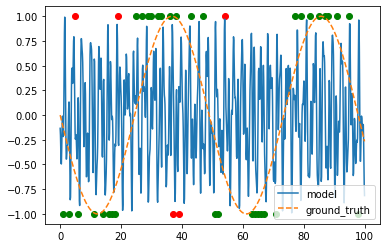

Iter:     8 | Cost: 1.4762875 | Accuracy: 0.4500000 


KeyboardInterrupt: 

In [397]:
opt = AdamOptimizer(stepsize=0.1)

layers=4
weights = pnp.random.rand(layers,requires_grad=True)
scaling = pnp.random.rand(layers,requires_grad=True)*3
dataset = np.loadtxt("../data/custom_dataset.txt")
X = pnp.array(dataset[:, :-2]).flatten()
Y = pnp.array(dataset[:, -2]).flatten()
X.requires_grad = False
Y.requires_grad = False
labels = pnp.array(dataset[:, -1])
BATCH_SIZE = len(X)

for it in range(1000):
    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, len(X), (BATCH_SIZE,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, scaling, _, _ = opt.step(cost, weights, scaling, X_batch, Y_batch)

    # Compute accuracy
    predictions = [np.sign(variational_classifier(weights, scaling, x)) for x in X]
    acc = accuracy(Y, predictions)
    
    model_plot = [variational_classifier(weights, scaling, x) for x in x_points]
    clear_output(wait=True)
    plt.plot(x_points,model_plot,label='model')
    plt.plot(x_points, np.sin(freq * x_points - np.pi),linestyle='dashed',label='ground_truth')
    plt.scatter(X[Y == labels], Y[Y == labels], color="green")
    plt.scatter(X[Y != labels], Y[Y != labels], color="red")
    plt.legend()
    plt.show()
    print(f"Iter: {it + 1:5d} | Cost: {cost(weights, scaling, X, Y):0.7f} | Accuracy: {acc:0.7f} ")



In [ ]:
plt.plot(x_points,model_plot)

## Regression example

In [522]:
import jax
import jax.numpy as jnp
import optax

In [523]:
def generate_data_regression(inputs: np.ndarray, noise: float = 0, freq=2 * np.pi / 10):
    """Function used to generate noisy data."""
    data = np.sin(freq * inputs - np.pi)
    # add some random noise to data
    noisy_data = data + np.random.normal(0,noise,len(data))
    return data, noisy_data

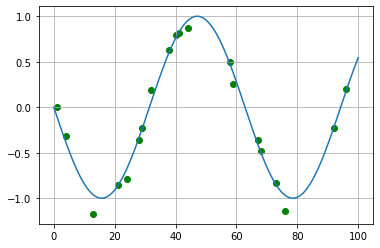

In [526]:
points = np.arange(0, 100, 1)
X = np.random.choice(points,20,replace=False)

freq= 0.1
labels, Y = generate_data_regression(X, noise=0.1,freq=freq)

# Save data
np.savetxt("../data/custom_dataset.txt", np.array([X, Y, labels]).T)

# Load data
dataset = np.loadtxt("../data/custom_dataset.txt")

X = np.array(dataset[:, :-2])
Y = np.array(dataset[:, -2])
labels = np.array(dataset[:, -1])

# Plot data
x_points = np.linspace(0, 100, 1000)

plt.scatter(X, Y, color="green")

plt.plot(x_points, np.sin(freq * x_points - np.pi))
plt.grid()
plt.show()

In [527]:
dev = qml.device("default.qubit", wires=1)
@jax.jit
@qml.qnode(dev,interface="jax")
def circuit(weights,scaling,input_data):
    for layer in range(len(weights)):
        qml.RX(input_data*scaling[layer],wires=0)
        qml.RY(weights[layer],wires=0)
    return qml.expval(qml.PauliZ(0))

vcircuit = jax.vmap(circuit,(None,None,0))

def square_loss(labels, predictions):
    """Square loss."""
    loss = jnp.sum((labels-predictions)**2)
    loss = loss/len(labels)
    return loss

def cost(params, input_data, labels):
    """Cost function."""
    predictions = variational_classifier(params['w'], params['s'], input_data)
    return square_loss(labels, predictions) #+ jnp.sum(params['s']**2)

def variational_classifier(weights, scaling, input_data):
    """Add classical bias."""
    return vcircuit(weights, scaling, input_data)

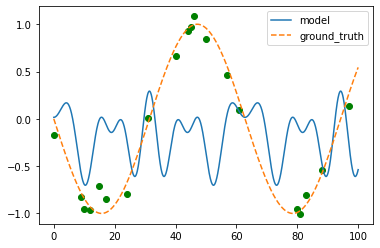

Iter:   991 | Cost: 0.4928756
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


In [521]:
layers=8
lr=0.01

params = {'w': pnp.random.rand(layers,requires_grad=True),
          's':pnp.ones(layers,requires_grad=True)*0.1}


dataset = np.loadtxt("../data/custom_dataset.txt")
X = pnp.array(dataset[:, :-2]).flatten()
Y = pnp.array(dataset[:, -2]).flatten()
X.requires_grad = False
Y.requires_grad = False
labels = pnp.array(dataset[:, -1])
BATCH_SIZE = len(X)

optimizer = optax.adam(lr)
opt_state = optimizer.init(params)

for it in range(1000):
    cst, grads = jax.value_and_grad(cost)(params, X, Y)
    updates, opt_state = optimizer.update(grads, opt_state)
    s_temp = params['s']
    params = optax.apply_updates(params, updates)
    params['s']=s_temp
    
    model_plot = variational_classifier(params['w'], params['s'], x_points)
    
    if it%10==0:
        clear_output(wait=True)
        plt.plot(x_points,model_plot,label='model')
        plt.plot(x_points, np.sin(freq * x_points - np.pi),linestyle='dashed',label='ground_truth')
        plt.scatter(X, Y, color="green")
        plt.legend()
        plt.show()
        print(f"Iter: {it + 1:5d} | Cost: {cst:0.7f}")
        print(params['s'])


    
    
    



## Quantum model

In [ ]:
import pennylane as qml
from pennylane import numpy as pnp
from pennylane.optimize import NesterovMomentumOptimizer


In [ ]:
dev = qml.device("default.qubit", wires=4)


def layer(weights):
    """Quantum layer."""
    qml.Rot(weights[0, 0], weights[0, 1], weights[0, 2], wires=0)
    qml.Rot(weights[1, 0], weights[1, 1], weights[1, 2], wires=1)
    qml.Rot(weights[2, 0], weights[2, 1], weights[2, 2], wires=2)
    qml.Rot(weights[3, 0], weights[3, 1], weights[3, 2], wires=3)

    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[3, 0])


@qml.qnode(dev)
def circuit(weights, input_data):
    """Quantum circuit."""
    qml.BasisState(input_data, wires=[0, 1, 2, 3])

    for weight in weights:
        layer(weight)

    return qml.expval(qml.PauliZ(0))


def variational_classifier(weights, bias, input_data):
    """Add classical bias."""
    return circuit(weights, input_data) + bias


def square_loss(labels, predictions):
    """Square loss."""
    loss = sum((label - prediction) ** 2 for label, prediction in zip(labels, predictions))

    loss /= len(labels)
    return loss


def accuracy(labels, predictions):
    """Accuracy function."""
    loss = 0
    for label, prediction in zip(labels, predictions):
        if abs(label - prediction) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss


def cost(weights, bias, input_data, labels):
    """Cost function."""
    predictions = [variational_classifier(weights, bias, x) for x in input_data]
    return square_loss(labels, predictions)


data = np.loadtxt("../data/parity.txt")
X = pnp.array(data[:, :-1], requires_grad=False)
Y = pnp.array(data[:, -1], requires_grad=False)
Y = Y * 2 - np.ones(len(Y))  # shift label from {0, 1} to {-1, 1}

for i in range(5):
    print(f"X = {X[i]}, Y = {Y[i]}")

print("...")

np.random.seed(0)
NUM_QUBITS = 4
NUM_LAYERS = 2
weights_init = 0.01 * pnp.random.randn(NUM_LAYERS, NUM_QUBITS, 3, requires_grad=True)
bias_init = pnp.array(0.0, requires_grad=True)

print(weights_init, bias_init)

opt = NesterovMomentumOptimizer(0.5)
BATCH_SIZE = 5

weights = weights_init
bias = bias_init
for it in range(25):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, len(X), (BATCH_SIZE,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, X_batch, Y_batch)

    # Compute accuracy
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]
    acc = accuracy(Y, predictions)

    print(f"Iter: {it + 1:5d} | Cost: {cost(weights, bias, X, Y):0.7f} | Accuracy: {acc:0.7f} ")
